# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This project aims to select the safest borough in London based on the total crimes, explore the neighborhoods of that borough to find the 10 most common venues in each neighborhood and finally cluster the neighborhoods using k-mean clustering.

This report will be targeted to people who are looking to relocate to London. Inorder to finalise a neighborhood to hunt for an apartment, safety is considered as a top concern when moving to a new place. If you don’t feel safe in your own home, you’re not going to be able to enjoy living there. The crime statistics will provide an insight into this issue.

We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* The total number of crimes commited in each of the borough during the last year.
* The most common venues in each of the neighborhood in the safest borough selected.


Following data sources will be needed to extract/generate the required information:
* Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016: A dataset consisting of the crime statistics of each borough in London obtained from Kaggle
* Part 2: Scraping additional information of the different Boroughs in London from a Wikipedia page.: More information regarding the boroughs of London is scraped using the Beautifulsoup library
* Part 3: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.: Co-ordinate of neighborhood will be obtained using Google Maps API geocoding

## Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016

#### Importing Libraries

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Define Foursquare Credentials and Version

In [4]:
CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K
CLIENT_SECRET:4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW


##### Reading the Dataset

In [5]:
df = pd.read_csv("london_crime_by_lsoa.csv")

In [6]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


### Fetching the most recent crime rates of 2016

In [7]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [8]:
df.shape

(392042, 7)

In [9]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


### Change the column names

In [10]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
LSOA_Code         392042 non-null object
Borough           392042 non-null object
Major_Category    392042 non-null object
Minor_Category    392042 non-null object
No_of_Crimes      392042 non-null int64
Year              392042 non-null int64
Month             392042 non-null int64
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


#### Total Number of crimes in Borough

In [12]:
df['Borough'].value_counts()

Lambeth                   17605
Southwark                 16560
Croydon                   16254
Newham                    15622
Ealing                    15284
Tower Hamlets             15219
Brent                     14980
Barnet                    14668
Hackney                   14392
Lewisham                  14235
Haringey                  14202
Enfield                   13658
Wandsworth                13498
Westminster               13383
Islington                 13116
Greenwich                 12750
Camden                    12632
Hillingdon                12417
Hounslow                  12316
Waltham Forest            12121
Bromley                   11980
Redbridge                 11490
Hammersmith and Fulham    10281
Barking and Dagenham       9784
Havering                   9699
Kensington and Chelsea     9653
Harrow                     8257
Bexley                     8245
Merton                     8223
Richmond upon Thames       7199
Sutton                     6823
Kingston

#### Total Crimes per Major Category

In [13]:
df['Major_Category'].value_counts()

Theft and Handling             129159
Violence Against the Person    123050
Criminal Damage                 48584
Burglary                        43020
Drugs                           21782
Robbery                         14889
Other Notifiable Offences       11558
Name: Major_Category, dtype: int64

In [14]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1287            1949   919   
Barnet                       3402            2183   906   
Bexley                       1123            1673   646   
Brent                        2631            2280  2096   
Bromley                      2214            2202   728   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       378     534               5607   
Barnet                                     499     464               9731   
Bexley                                     294     209               4392   
Brent                                      536     919               9026   
Bromley                                    417     369               7584   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        6067  
Barnet                                      7499  
Bexley                                      4503  
Brent                                       9205  
Bromley                                     6650

In [15]:
London_crime.reset_index(inplace =True)

In [16]:
# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(33)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham         1287            1949   919   
1                               Barnet         3402            2183   906   
2                               Bexley         1123            1673   646   
3                                Brent         2631            2280  2096   
4                              Bromley         2214            2202   728   
5                               Camden         2652            1935  1493   
6                       City of London            2               2    10   
7                              Croydon         2738            3219  1367   
8                               Ealing         2492            2562  1355   
9                              Enfield         2541            2136  1063   
10                           Greenwich         1780            2476   867   
11                             Hackney         2719            1981  1353   
12              Hammersmith and Fulham         1531            1408  1321   
13                            Haringey         2474            2233  1540   
14                              Harrow         1994            1212   473   
15                            Havering         1826            1804   718   
16                          Hillingdon         2229            2470  1042   
17                            Hounslow         1808            2213  1086   
18                           Islington         2051            1903  1777   
19              Kensington and Chelsea         1449            1051  1680   
20                Kingston upon Thames          879            1054   743   
21                             Lambeth         3087            2764  2738   
22                            Lewisham         2071            2351  1617   
23                              Merton         1419            1418   466   
24                              Newham         2115            2496  1684   
25                           Redbridge         1997            1650  1017   
26                Richmond upon Thames         1359            1148   320   
27                           Southwark         2946            2621  1838   
28                              Sutton         1233            1316   461   
29                       Tower Hamlets         2794            2357  1629   
30                      Waltham Forest         1873            1989  1042   
31                          Wandsworth         2351            1836   870   
32                         Westminster         3218            2179  2049   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    378     534               5607   
1                                    499     464               9731   
2                                    294     209               4392   
3                                    536     919               9026   
4                                    417     369               7584   
5                                    490     899              14088   
6                                      6       4                129   
7                                    718    1139               9229   
8                                    613     669              10040   
9                                    492     807               8037   
10                                   521     486               8010   
11                                   499    1030              11851   
12                                   474     397               8925   
13                                   551    1248              10554   
14                                   267     377               4537   
15                                   389     311               5919   
16                                  1305     420         

####  Removing the Multi Index for easy merge

In [17]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [18]:

London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [20]:
London_crime.shape

(33, 9)

# Part 2: Scraping Information

### Using Beautiful Soup

URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [21]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"86a27141-e649-4893-bef9-16130e976bdd","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":958873870,"wgRevisionId":958873870,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of 

In [23]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

#### Creating a dataframe from a table

In [24]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [25]:
# verifying the last row
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
27,Sutton,NaN,NaN,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,18
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2


#### View the information of the dataset

In [26]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
Borough                     32 non-null object
Inner                       3 non-null object
Status                      4 non-null object
Local authority             32 non-null object
Political control           32 non-null object
Headquarters                32 non-null object
Area (sq mi)                32 non-null float64
Population (2013 est)[1]    32 non-null int64
Co-ordinates                32 non-null object
Nr. in map                  32 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 2.6+ KB


In [27]:
#Removing uncessary string from the Data Set
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [28]:
type(London_table)

pandas.core.frame.DataFrame

In [29]:
# Shape of the data frame
London_table.shape

(32, 10)

In [30]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham',
 'City of London',
 'Greenwich',
 'Hammersmith and Fulham'}

##### Finding the Index that didn't match

In [31]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


In [32]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

In [33]:

set(df.Borough) - set(London_table.Borough)

{'City of London'}

### Now we combine the dataframes together

In [34]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,3402,2183,906,499,464,9731,7499,24684,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,2631,2280,2096,536,919,9026,9205,26693,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,2214,2202,728,417,369,7584,6650,20164,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,2652,1935,1493,490,899,14088,7626,29183,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,Croydon,2738,3219,1367,718,1139,9229,10302,28712,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
7,Ealing,2492,2562,1355,613,669,10040,9396,27127,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
8,Enfield,2541,2136,1063,492,807,8037,7409,22485,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
9,Greenwich,1780,2476,867,521,486,8010,8590,22730,[],Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E,22


In [35]:
Ld_crime.shape

(32, 18)

In [36]:
set(df.Borough) - set(Ld_crime.Borough)

{'City of London'}

In [37]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,3402,2183,906,499,464,9731,7499,24684,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,2631,2280,2096,536,919,9026,9205,26693,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,2214,2202,728,417,369,7584,6650,20164,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,2652,1935,1493,490,899,14088,7626,29183,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,Croydon,2738,3219,1367,718,1139,9229,10302,28712,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
7,Ealing,2492,2562,1355,613,669,10040,9396,27127,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
8,Enfield,2541,2136,1063,492,807,8037,7409,22485,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
9,Greenwich,1780,2476,867,521,486,8010,8590,22730,[],Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E,22


In [38]:
Ld_crime.shape

(32, 18)

In [39]:
set(df.Borough) - set(Ld_crime.Borough)

{'City of London'}

#### Rearranging the columns

In [40]:
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [41]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,1287,1949,919,378,534,5607,6067,16741
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3402,2183,906,499,464,9731,7499,24684
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12840
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2214,2202,728,417,369,7584,6650,20164


## Methodology

#### The methodology in this project consists of two parts:

* Exploratory Data Analysis : Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.

* Modelling: To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.

### Exploratory Data Analysis

In [42]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2069.242424,1941.545455,1179.212121,479.060606,682.666667,8913.121212,7041.848485,22306.696970
std,737.448644,625.207070,586.406416,223.298698,441.425366,4620.565054,2513.601551,8828.228749
min,2.000000,2.000000,10.000000,6.000000,4.000000,129.000000,25.000000,178.000000
25%,1531.000000,1650.000000,743.000000,378.000000,377.000000,5919.000000,5936.000000,16903.000000
50%,2071.000000,1989.000000,1063.000000,490.000000,599.000000,8925.000000,7409.000000,22730.000000
75%,2631.000000,2351.000000,1617.000000,551.000000,936.000000,10789.000000,8832.000000,27174.000000
max,3402.000000,3219.000000,2738.000000,1305.000000,1822.000000,27520.000000,10834.000000,48330.000000


In [43]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.1


In [44]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Ld_crime.columns)

True

In [45]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
31,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3218,2179,2049,708,1822,27520,10834,48330
20,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,3087,2764,2738,635,1196,13155,10496,34071
26,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2946,2621,1838,494,1317,12946,9474,31636
23,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2115,2496,1684,713,1472,11964,9646,30090
28,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,2794,2357,1629,678,1234,10953,9608,29253


#### Visualizing highest number of crimes

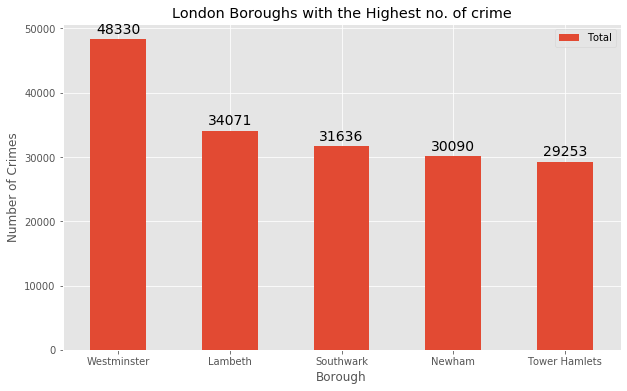

In [46]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [47]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
19,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,879,1054,743,189,121,3803,3194,9983
27,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1233,1316,461,253,165,3516,3714,10658
25,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1359,1148,320,217,106,4769,3155,11074
22,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,1419,1418,466,249,283,4894,4026,12755
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12840


#### Visualizing with Least Number of crimes

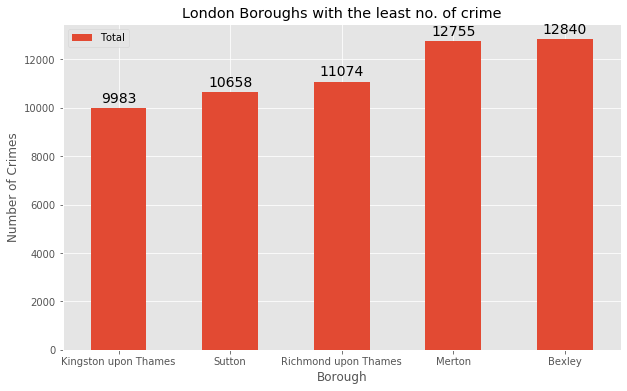

In [48]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [49]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]


## Visualizing in Kingston upon Thames

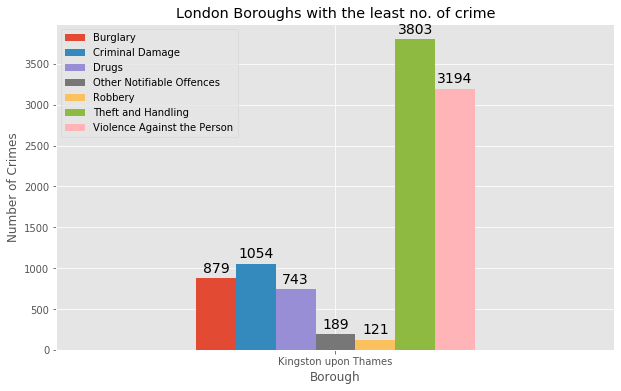

In [50]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Part 3: Creating a new dataset & generating their co-ordinates

In [53]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


In [54]:
# Finding Co-ordinates

Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    geolocator=Nominatim(timeout=10)
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)


C:\Users\Rahul Raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  if __name__ == '__main__':


[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [55]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


In [56]:
#Getting the coordinates of Berrylands, London
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


#### Visualizing

In [57]:
#create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

### Modeling

In [58]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [59]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [60]:
print(kut_venues.shape)
kut_venues.head()

(174, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Berrylands,51.393781,-0.284802,SK Superstores,51.389901,-0.283278,Convenience Store
4,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park


In [61]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,4,4,4,4,4,4
Canbury,14,14,14,14,14,14
Coombe,1,1,1,1,1,1
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,8,8,8,8,8,8


In [62]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 73 uniques categories.


### One hot encoding

In [63]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Coombe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kingston upon Thames,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.033333,0.000000
6,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Norbiton,0.000000,0.035714,0.035714,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.035714,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714


In [65]:
kut_grouped.shape

(14, 74)

In [66]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                   venue  freq
0                   Park  0.25
1   Gym / Fitness Center  0.25
2      Convenience Store  0.25
3               Bus Stop  0.25
4  Portuguese Restaurant  0.00


----Canbury----
                  venue  freq
0                   Pub  0.29
1           Supermarket  0.07
2  Gym / Fitness Center  0.07
3     Fish & Chips Shop  0.07
4                  Park  0.07


----Coombe----
              venue  freq
0          Tea Room   1.0
1  Asian Restaurant   0.0
2            Market   0.0
3          Platform   0.0
4       Pizza Place   0.0


----Hook----
                venue  freq
0         Supermarket  0.25
1              Bakery  0.25
2   Indian Restaurant  0.25
3   Fish & Chips Shop  0.25
4  Mexican Restaurant  0.00


----Kingston Vale----
            venue  freq
0   Grocery Store  0.25
1    Soccer Field  0.25
2             Bar  0.25
3  Sandwich Place  0.25
4        Platform  0.00


----Kingston upon Thames----
              venue  freq
0              C

In [67]:
# Creating a new Data Frame for Venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Convenience Store,Gym / Fitness Center,Park,Bus Stop,Fast Food Restaurant,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market
1,Canbury,Pub,Fish & Chips Shop,Plaza,Supermarket,Spa,Gym / Fitness Center,Shop & Service,Park,Café,Hotel
2,Coombe,Tea Room,Wine Shop,Fish & Chips Shop,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
3,Hook,Indian Restaurant,Fish & Chips Shop,Bakery,Supermarket,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
4,Kingston Vale,Grocery Store,Bar,Soccer Field,Sandwich Place,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store


## Clustering Neighbourhoods using K-Means

In [70]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generat
kmeans.labels_[0:10]

array([0, 4, 3, 2, 1, 4, 1, 0, 4, 4])

In [71]:
 #add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,0.0,Convenience Store,Gym / Fitness Center,Park,Bus Stop,Fast Food Restaurant,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market
1,Canbury,Kingston upon Thames,51.417499,-0.305553,4.0,Pub,Fish & Chips Shop,Plaza,Supermarket,Spa,Gym / Fitness Center,Shop & Service,Park,Café,Hotel
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,3.0,Tea Room,Wine Shop,Fish & Chips Shop,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
4,Hook,Kingston upon Thames,51.367898,-0.307145,2.0,Indian Restaurant,Fish & Chips Shop,Bakery,Supermarket,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant


In [72]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
Neighborhood              15 non-null object
Borough                   15 non-null object
Latitude                  15 non-null float64
Longitude                 15 non-null float64
Cluster Labels            14 non-null float64
1st Most Common Venue     14 non-null object
2nd Most Common Venue     14 non-null object
3rd Most Common Venue     14 non-null object
4th Most Common Venue     14 non-null object
5th Most Common Venue     14 non-null object
6th Most Common Venue     14 non-null object
7th Most Common Venue     14 non-null object
8th Most Common Venue     14 non-null object
9th Most Common Venue     14 non-null object
10th Most Common Venue    14 non-null object
dtypes: float64(3), object(12)
memory usage: 1.9+ KB


In [73]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [74]:
kut_merged.shape

(14, 15)

In [75]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [76]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 15 columns):
Neighborhood              14 non-null object
Borough                   14 non-null object
Latitude                  14 non-null float64
Longitude                 14 non-null float64
Cluster Labels            14 non-null int32
1st Most Common Venue     14 non-null object
2nd Most Common Venue     14 non-null object
3rd Most Common Venue     14 non-null object
4th Most Common Venue     14 non-null object
5th Most Common Venue     14 non-null object
6th Most Common Venue     14 non-null object
7th Most Common Venue     14 non-null object
8th Most Common Venue     14 non-null object
9th Most Common Venue     14 non-null object
10th Most Common Venue    14 non-null object
dtypes: float64(2), int32(1), object(12)
memory usage: 1.7+ KB


### Visualizing Clusters

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## Analysis

In [78]:

kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,0,Convenience Store,Gym / Fitness Center,Park,Bus Stop,Fast Food Restaurant,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,0,Gym,Park,Bus Stop,Soccer Field,Wine Shop,Fast Food Restaurant,Department Store,Discount Store,Dry Cleaner,Electronics Store


In [79]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138,1,Grocery Store,Bar,Soccer Field,Sandwich Place,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,1,Grocery Store,Garden Center,Pub,Restaurant,Farmers Market,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,1,Grocery Store,Pharmacy,Restaurant,Bowling Alley,Furniture / Home Store,Hotel,Discount Store,Pizza Place,Bus Stop,Sandwich Place


In [80]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Hook,Kingston upon Thames,51.367898,-0.307145,2,Indian Restaurant,Fish & Chips Shop,Bakery,Supermarket,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant


In [81]:
#Examining 4th CLuster
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.41945,-0.265398,3,Tea Room,Wine Shop,Fish & Chips Shop,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant


In [82]:
#Examining 5th Custer
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,4,Pub,Fish & Chips Shop,Plaza,Supermarket,Spa,Gym / Fitness Center,Shop & Service,Park,Café,Hotel
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,4,Café,Pub,Sushi Restaurant,Coffee Shop,Burger Joint,Asian Restaurant,French Restaurant,German Restaurant,Gift Shop,Turkish Restaurant
9,New Malden,Kingston upon Thames,51.405335,-0.263407,4,Gastropub,Gym,Chinese Restaurant,Sushi Restaurant,Supermarket,Bar,Korean Restaurant,Indian Restaurant,Fast Food Restaurant,Discount Store
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,4,Indian Restaurant,Food,Italian Restaurant,Platform,Pub,Wine Shop,Rental Car Location,Dry Cleaner,Hardware Store,Hotel
11,Old Malden,Kingston upon Thames,51.382484,-0.259090,4,Construction & Landscaping,Train Station,Pub,Food,Farmers Market,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Dry Cleaner
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,4,Indian Restaurant,Coffee Shop,Pub,Hotel,Playground,Chinese Restaurant,Italian Restaurant,Café,Restaurant,Pet Café
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,4,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Pharmacy,Breakfast Spot,Gastropub,French Restaurant,Farmers Market,Gym / Fitness Center


### Results & Discussion

The aim of this project is to help people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable. For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family.

### Conclusion

This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget.